In [8]:
import numpy as np
from numpy import linalg
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cvxopt
from cvxopt import matrix, solvers 

In [9]:
df = pd.read_csv('Classify-2D-wLabels-3.txt', sep=',', header=None, names=["Col1", "Col2", "Class"])
df["Class"] = df[["Class"]].replace(0,-1)
df.head()

,Col1,Col2,Class
0,-0.50,0.73,-1
1,0.68,-0.41,1
2,0.81,-0.15,1
3,-0.63,0.41,1
4,-0.37,0.86,-1


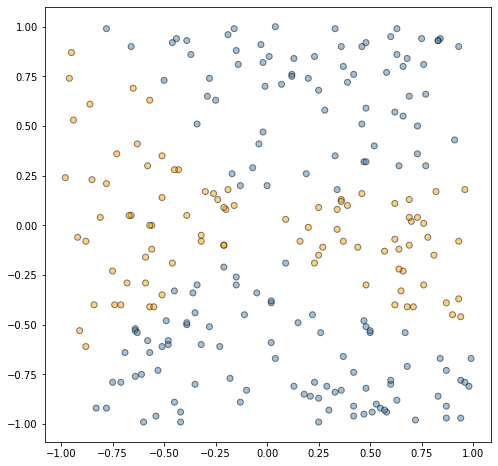

In [10]:
X_data = df[["Col1", "Col2"]].to_numpy()
y_data = df[["Class"]].to_numpy()


plt.figure(figsize=(8, 8))
colors = ["steelblue", "orange"]
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.show()

In [11]:
y_data = y_data.reshape(-1)
print(y_data.shape)


(250,)


In [12]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel3(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def polynomial_kernel4(x, y, p=4):
    return (1 + np.dot(x, y)) ** p

In [13]:
class SVM(object):
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples), 'd')
        b = cvxopt.matrix(0.0)
        
        
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))


        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
    
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
        return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))


     pcost       dcost       gap    pres   dres
 0: -1.0015e+02 -2.3521e+02  1e+03  3e+01  2e+00
 1: -3.0602e+02 -3.5760e+02  5e+02  1e+01  1e+00
 2: -4.8881e+02 -5.4880e+02  5e+02  1e+01  1e+00
 3: -1.2938e+03 -1.3877e+03  6e+02  1e+01  1e+00
 4: -3.1089e+03 -3.2342e+03  8e+02  1e+01  1e+00
 5: -6.0103e+03 -6.1926e+03  1e+03  1e+01  1e+00
 6: -6.9120e+03 -7.2293e+03  2e+03  1e+01  1e+00
 7: -7.6344e+03 -8.5235e+03  4e+03  1e+01  8e-01
 8: -7.5779e+03 -8.7210e+03  4e+03  5e+00  4e-01
 9: -6.6339e+03 -6.8179e+03  4e+02  2e-01  2e-02
10: -6.6055e+03 -6.6078e+03  5e+00  3e-03  2e-04
11: -6.6051e+03 -6.6051e+03  5e-02  3e-05  2e-06
12: -6.6051e+03 -6.6051e+03  5e-04  3e-07  2e-08
13: -6.6051e+03 -6.6051e+03  5e-06  3e-09  2e-10
Optimal solution found.
250 out of 250 predictions correct


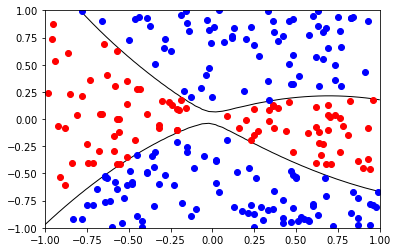

     pcost       dcost       gap    pres   dres
 0: -7.5925e+01 -1.7820e+02  1e+03  3e+01  2e+00
 1: -2.3716e+02 -3.0519e+02  5e+02  2e+01  1e+00
 2: -5.4857e+02 -6.2259e+02  6e+02  2e+01  1e+00
 3: -1.4696e+03 -1.5516e+03  7e+02  2e+01  1e+00
 4: -2.9572e+03 -3.0665e+03  8e+02  1e+01  1e+00
 5: -3.8373e+03 -4.0797e+03  2e+03  1e+01  9e-01
 6: -4.0578e+03 -4.3155e+03  2e+03  1e+01  8e-01
 7: -4.0884e+03 -4.2180e+03  3e+03  9e+00  6e-01
 8: -3.3444e+03 -3.4073e+03  3e+03  7e+00  5e-01
 9: -2.6640e+03 -2.7416e+03  2e+03  3e+00  2e-01
10: -2.1901e+03 -2.5001e+03  1e+03  2e+00  1e-01
11: -2.1510e+03 -2.2862e+03  4e+02  4e-01  3e-02
12: -2.1256e+03 -2.2086e+03  8e+01  3e-13  2e-12
13: -2.1971e+03 -2.2013e+03  4e+00  2e-13  2e-12
14: -2.2009e+03 -2.2009e+03  4e-02  5e-13  2e-12
15: -2.2009e+03 -2.2009e+03  4e-04  3e-13  2e-12
Optimal solution found.
250 out of 250 predictions correct


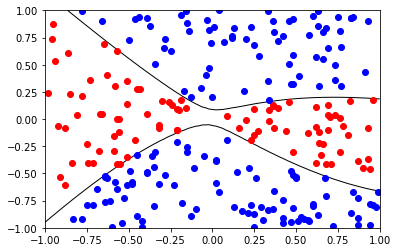

In [14]:
if __name__ == "__main__":
    import matplotlib.pyplot as pl

    

    
    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")        
        X1, X2 = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.axis("tight")
        pl.show()
    

    
              
    def test_non_linear3():
        clf = SVM(polynomial_kernel3)
        clf.fit(X_data, y_data)
        y_predict = clf.predict(X_data)
        correct = np.sum(y_predict == y_data)
        print(correct, "out of", len(y_predict), "predictions correct")
        plot_contour(X_data[y_data==1], X_data[y_data==-1], clf)
        
        
    def test_non_linear4():
        clf = SVM(polynomial_kernel4)
        clf.fit(X_data, y_data)
        y_predict = clf.predict(X_data)
        correct = np.sum(y_predict == y_data)
        print(correct, "out of", len(y_predict), "predictions correct")
        plot_contour(X_data[y_data==1], X_data[y_data==-1], clf)
    
    test_non_linear3()
    test_non_linear4()